In [1]:
%run common_init.py

Start import
Host: DESKTOP-URE1BBI.localdomain
Setting tmp folder to /tmp/
calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done
Done import
SYSTEM
	Running on linux
	Python version 3.8.0 (default, Nov  6 2019, 21:49:08) [GCC 7.3.0]
	Python installation /home/joran/miniconda3/envs/dddm2/bin/python
MODULES
	DirectDmTargets
		ver.:	0.2.0
		Path:	/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/

	wimprates
		ver.:	0.3.2
		Path:	/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/



In [2]:
save_dir = '/home/joran/google_drive/200202_results_dddm'

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

02 Jan. 2020


## HALO model ##
In DirectDmTargets (dddm) we have two ways of generating spectra:
 - Directly from wimprates. See: <https://github.com/jorana/wimprates> (cloned from  <https://github.com/JelleAalbers/wimprates>) 
 - Loading velocity distributions from verne into wimprates to generate a spectrum of dark matter by integrating the velocity distribution with wimprates <https://github.com/jorana/verne> (cloned from <https://github.com/bradkav/verne>)


In [3]:
plt.rcParams['axes.grid'] = True

In [4]:
def n_int_f(f,v):
    '''numerically calculate the integral of f*v*dv'''
    bin_widths = v[1:]-v[:-1]
    av_bin_width = np.mean(bin_widths)
    assert np.all(abs(bin_widths-av_bin_width) -1 < 0.01), "use equal bin-spacing"
    return np.sum(f * v * bin_widths[0])

Num. int. of SHM=	1.0
looking for sig_-35.0_mx_0.00_avg in ['sig_-35.0_mx_0.00_avg.csv']
sig_-35.0_mx_0.00_avg is in  sig_-35.0_mx_0.00_avg.csv!
VerneSHM::	looking for "sig_-35.0_mx_0.00_avg" in "/mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/". That folder has "['sig_-35.0_mx_0.00_avg.csv']". 
	Does it have the right file?
	True
looking for sig_-35.0_mx_0.00_avg in ['sig_-35.0_mx_0.00_avg.csv']
sig_-35.0_mx_0.00_avg is in  sig_-35.0_mx_0.00_avg.csv!
VerneSHM::	Using sig_-35.0_mx_0.00_avg.csv since it has sig_-35.0_mx_0.00_avg
VerneSHM::	Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg.csv as input
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -35=	1.0084209965671802
looking for sig_-34.0_mx_0.00_avg in ['sig_-35.0_mx_0.00_avg.csv']
sig_-34.0_mx_0.00_avg is not in  sig_-35.0_mx_0.00_avg.c

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


Num. int. of -34=	0.7775561111554893
looking for sig_-33.0_mx_0.00_avg in ['sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-35.0_mx_0.00_avg.csv']
sig_-33.0_mx_0.00_avg is not in  sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-33.0_mx_0.00_avg is not in  sig_-35.0_mx_0.00_avg.csv
VerneSHM::	looking for "sig_-33.0_mx_0.00_avg" in "/mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/". That folder has "['sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-35.0_mx_0.00_avg.csv']". 
	Does it have the right file?
	False
looking for sig_-33.0_mx_0.00_avg in ['sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-35.0_mx_0.00_avg.csv']
sig_-33.0_mx_0.00_avg is not in  sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-33.0_mx_0.00_avg is not in  sig_-35.0_mx_0.00_avg.csv
VerneSHM::	No file found
No spectrum found at:
/mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/sig_-33.0_mx_0.00_

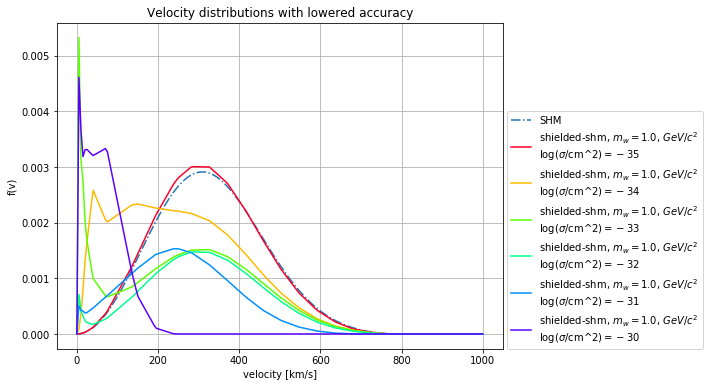

In [5]:
# Plot -options
plt.figure(figsize = (8,6))
nplots = 7
cm = plt.get_cmap('gist_rainbow')

# velocity
vel = np.linspace(0,1000,200)

# load standard-halo-model spectrum with given parameters
args = dict(v_0=230* nu.km / nu.s, v_esc = 544* nu.km / nu.s, rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
shm_dist = dddm.SHM(**args)
f = shm_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km/nu.s
plt.plot(vel, f, label = 'SHM', linestyle = '-.')
int_shm = n_int_f(f,vel)
print(f'Num. int. of {"SHM"}=\t{int_shm/int_shm}')

# Make the mass and the location explicit
log_mw = 0
loc = "XENON"
s_min, s_max, d_s = -35, -29, 1 # plot: from - to - with steps
nplots = nplots = (s_max - s_min)  // d_s
# loop over cross-sections
for i, sig in enumerate(np.arange(s_min, s_max, d_s)):
    args['log_cross_section'] = sig
    args['log_mass'] = log_mw
    args['location'] = loc
    verne_dist = dddm.VerneSHM(**args)
    f = verne_dist.velocity_dist(vel*nu.km/nu.s, 0)*nu.km/nu.s
    plt.plot(vel, f, 
             c = cm(float(i)/nplots),
             label = f'shielded-shm, $m_w=%.1f$, $GeV/c^2$\n$\log(\sigma/$cm^2$) = {sig}$'%(10**log_mw))
    print(f'Num. int. of {sig}=\t{n_int_f(f,vel)/int_shm}')
plt.legend(loc=(1.01,0))
plt.xlabel('velocity [km/s]')
plt.ylabel('f(v)')
plt.title('Velocity distributions with lowered accuracy')
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/quick_verne.{f_type}', dpi = 100, bbox_inches= 'tight')

# Load the full verne simulation
below we load the full verne simulation with the default options, this takes somewhat longer than the procedure as on the forked verne code as linked above.

In [6]:
# Command to load
save = "/mnt/c/Users/Joran/dddm_data/verne/full_spec.csv" 
if not os.path.exists(save):
    !python "/home/joran/google_drive/windows-anaconda/verne/"/src/CalcVelDist_full.py -m_x 1 -sigma_p 1e-34 -loc XENON -path "/home/joran/google_drive/windows-anaconda/verne//src/" -v_0 229.99999999999997 -v_esc 544.0 -save_as $save

In [7]:
# A copy of the full spectrum has been saved at:
df = pd.read_csv('/home/joran/google_drive/windows-anaconda/verne/results/full_veldists/f_all_XENON_229_544_-78.3_1.00.csv')

# The df contains several values of the angle gamma, disentangle those here:
_,x,y  = df.keys()
headers = np.unique(df['gamma/pi'].values)
def get_average(df, headers, projection):
    masks = np.array([df['gamma/pi'] == header for header in headers])
    combined = np.array([df[mask][projection].values for mask in masks])
    return np.average(combined,axis = 0)
df_average = pd.DataFrame()
for projection in [x,y]:
    df_average[projection] = get_average(df, headers, projection)

# The different angles
headers = np.unique(df['gamma/pi'].values)
n_headers = len(headers)

### plot verne
below we plot the full verne calculation and compare it with the calculation as performed by the forked github branch as linked above

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


looking for sig_-34.0_mx_0.00_avg in ['sig_-30.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-31.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-32.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-33.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-35.0_mx_0.00_avg.csv']
sig_-34.0_mx_0.00_avg is not in  sig_-30.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-34.0_mx_0.00_avg is not in  sig_-31.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-34.0_mx_0.00_avg is not in  sig_-32.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-34.0_mx_0.00_avg is not in  sig_-33.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv
sig_-34.0_mx_0.00_avg is in  sig_-34.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv!
VerneSHM::	looking for "sig_-34.0_mx_0.00_avg" in "/mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_230/vesc_544/rho_0.300/". That folder has "['sig_-30.0_mx_0.00_avg-DESKTOP-URE1BBI.localdomain.csv', 'sig_-3

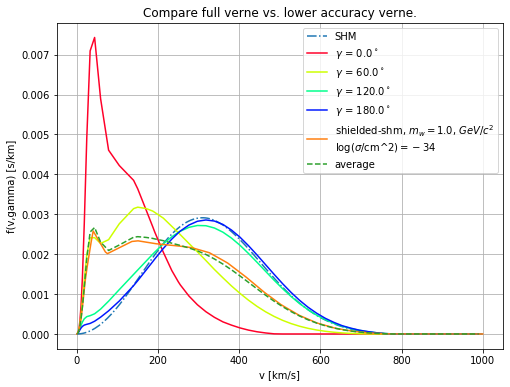

In [8]:
# Plot options
plt.figure(figsize = (8,6))
plt.xlabel("v [km/s]")

# Plot shm
plt.plot(vel, shm_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km /nu.s, label = 'SHM', linestyle = '-.')
plt.ylim()*2

# Plot for the angles
for i, header in enumerate(headers):
    mask = df['gamma/pi'] == header
    kwargs = {'color': cm(float(i)/n_headers),
        'label': '$\gamma$ = %.1f$^\circ$'%np.rad2deg(header*np.pi)}
    plt.plot(df[mask][x], df[mask][y], **kwargs)    
    plt.ylabel(y.replace("_"," "))
    
# Again plot the corresponding distribution as done above
sig = -34
args['log_cross_section'] = sig
verne_dist = dddm.VerneSHM(**args)
f_quick = verne_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km /nu.s
plt.plot(vel, f_quick, 
     label = f'shielded-shm, $m_w=%.1f$, $GeV/c^2$\n$\log(\sigma/$cm^2$) = {sig}$'%(10**log_mw))
quick_ratio = n_int_f(f_quick, vel)/int_shm
print(f'Num. int. at average (quick)=\t{quick_ratio}')

# Also plot the average of the full simulation
plt.plot(df_average[x],df_average[y], label = 'average', linestyle = '--')
def f_in(x0,y0, x):
        return scipy.interpolate.interp1d(x0,y0, bounds_error=False, fill_value=0)(x)
full_ratio = n_int_f(f_in(df_average[x], df_average[y], vel), vel)/int_shm
print(f'Num. int. at average (full) =\t{full_ratio}')
plt.legend()
plt.title('Compare full verne vs. lower accuracy verne.')


print(f'Quick method is off by %.1f'%(100 * (1-quick_ratio / full_ratio)) + '%')
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/compare_verne.{f_type}', dpi = 100, bbox_inches= 'tight')
    


In [9]:
# No detector resolution
def plot_spectrum(data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                markersize =3,
                label = label
                )
def plot_spectrum_ax(ax, data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    print(np.sum(data['counts']))
    ax.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                markersize =3,
                label = label
                )
def get_gal_spec(det, mw = 1, sigma = 1e-34, nbins = 10):
    events = dddm.GenSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    return events.get_data(poisson = False)

In [11]:
use_SHM = dddm.SHM()

In [12]:
def get_det_spec(det, mw = 1, sigma = 1e-34, nbins = 10, background = True, shm = use_SHM):
    events = dddm.DetectorSpectrum(mw, sigma, shm, dddm.experiment[det])
    events.n_bins = nbins
    events.add_background = background
    return events.get_data(poisson = False)

In [13]:
def plot_spectra(det, mw = 1, sigma = 1e-34, nbins = 10):
    fig, (ax1,ax2) = plt.subplots(2, figsize = (14,8), sharex = True)
    
    gal_spec = get_gal_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins, background = False)
    
    ax1.set_title('spectrum log. scale')
    plot_spectrum_ax(ax1, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters (gal_spec)')
    
    plot_spectrum_ax(ax1,bg_spec,color =  'black', 
                     label = f'{det} (bg_spec)')

    ax1.set_ylim(bottom=np.max([plt.ylim()[-1], (1e-10 * 10/nbins)]))
    ax1.set_yscale("log")
    
    ax2.set_title('spectrum lin. scale')
    plot_spectrum_ax(ax2, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters')
    plot_spectrum_ax(ax2,bg_spec,color =  'black', 
                     label = f'{det}')
    ax2.set_ylim(0, 2 * bg_spec['counts'].max())
    for ax in [ax1,ax2]:
        ax.axvline(dddm.experiment[det]['E_thr'], label = 'energy threshold')
        ax.grid(axis="both")
        ax.set_ylabel('counts/keV')
        ax.legend()
    plt.xlabel('E [keV]')

In [14]:
args = dict(v_0=230* nu.km / nu.s, v_esc = 544* nu.km / nu.s, rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
use_SHM = dddm.SHM(**args)

KeyboardInterrupt: 

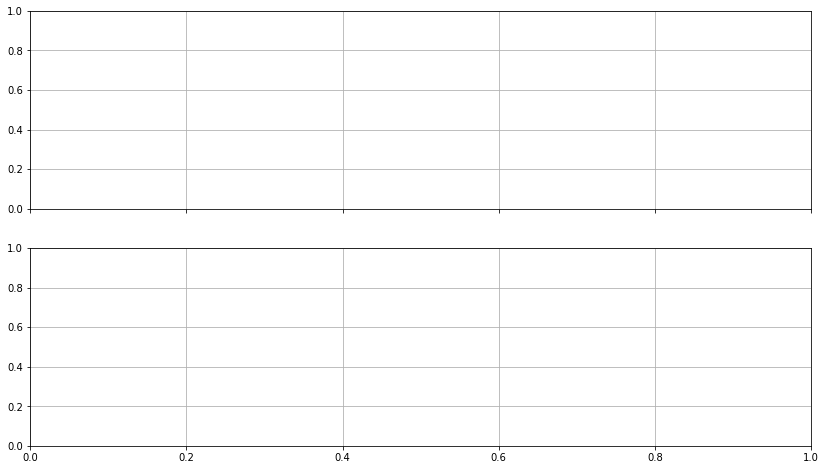

In [15]:
%%time
plot_spectra('Xe_migd', nbins = 1000)
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/shm_det.spectrum1.{f_type}', dpi = 100, bbox_inches= 'tight')

In [ ]:
log_mw = 0
loc = "XENON"
sig = -34
args['log_cross_section'] = sig
args['log_mass'] = log_mw
args['location'] = loc
use_SHM = dddm.VerneSHM(**args)


In [ ]:
%%time
plot_spectra('Xe_migd', nbins = 1000)
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/verne_det.spectrum2.{f_type}', dpi = 100, bbox_inches= 'tight')

# Using dddm to get different spectra at a given variation of v0

In [16]:
def spectra_for_shm(ax, det, shm, label ="", mw = 1, sigma = 1e-34, nbins = 10, c = 'red'):
    
    
#     gal_spec = get_gal_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    bg_spec = get_det_spec(det, mw = mw, 
                           sigma = sigma, nbins = nbins, background = False, shm = shm)
    
#     ax1.set_title('spectrum log. scale')
    plot_spectrum_ax(ax1, bg_spec, color = c,
                     label = label)
    
#     plot_spectrum_ax(ax1,bg_spec,color =  'black', 
#                      label = f'{det} (bg_spec)')

#     ax1.set_ylim(bottom=np.max([plt.ylim()[-1], (1e-10 * 10/nbins)]))
#     ax1.set_yscale("log")
    
#     ax2.set_title('spectrum lin. scale')
#     plot_spectrum_ax(ax2, gal_spec, color = 'red', 
#                      label = f'{det} without det. parameters')
#     plot_spectrum_ax(ax2,bg_spec,color =  'black', 
#                      label = f'{det}')
#     ax2.set_ylim(0, 2 * bg_spec['counts'].max())
#     for ax in [ax1,ax2]:
#         ax.axvline(dddm.experiment[det]['E_thr'], label = 'energy threshold')
#         ax.grid(axis="both")
#         ax.set_ylabel('counts/keV')
#         ax.legend()
    plt.xlabel('E [keV]')

25719.397075850993
162268.15294278867
521988.00346206257
1091751.8091795458
1708633.061628695
2191938.4547614334
2450393.508970045


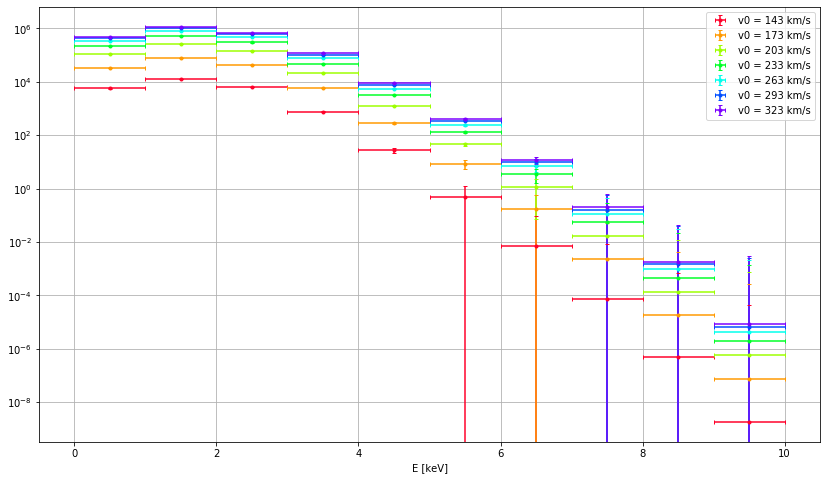

In [17]:
fig, (ax1) = plt.subplots(1, figsize = (14,8), sharex = True)
vlist = np.arange(233-90,233+90+1, 30)
for i, v_0 in enumerate(vlist):
    args = dict(v_0=v_0* nu.km / nu.s, 
                v_esc = 544* nu.km / nu.s, 
                rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
    use_SHM = dddm.SHM(**args)
    spectra_for_shm(ax1, 'Xe_migd', use_SHM, nbins = 10, 
                    label = f'v0 = {v_0} km/s', c = cm(float(i)/len(vlist)) )
plt.legend()
plt.yscale("log")

359145.4953676917
572559.7234836292
796029.7486304789
1002960.9112120275
1176045.684756357
1308733.5363237793
1402958.3288944347


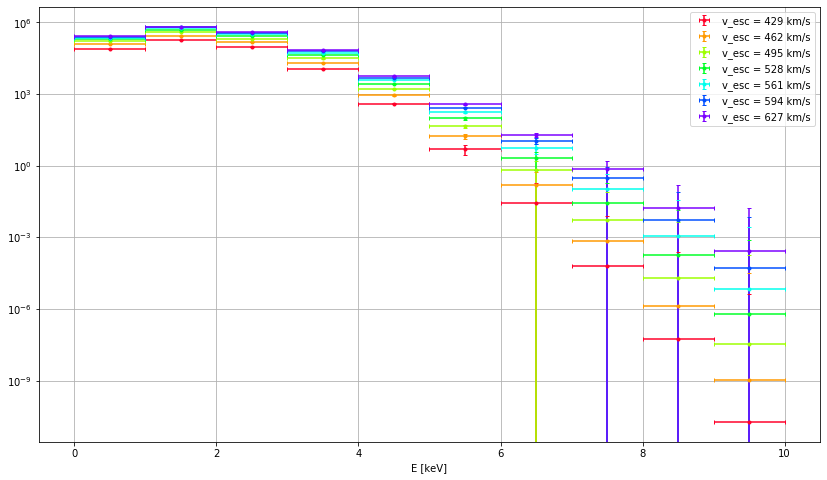

In [18]:
fig, (ax1) = plt.subplots(1, figsize = (14,8), sharex = True)
vlist = np.arange(528-99,528+99+1, 33)
for i, v_esc in enumerate(vlist):
    args = dict(v_0=233* nu.km / nu.s, 
                v_esc = v_esc* nu.km / nu.s, 
                rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
    use_SHM = dddm.SHM(**args)
    spectra_for_shm(ax1, 'Xe_migd', use_SHM, nbins = 10, 
                    label = f'v_esc = {v_esc} km/s', c = cm(float(i)/len(vlist)) )
plt.legend()
plt.yscale("log")

In [19]:
path = "/mnt/c/Users/Joran/dddm_data/spectra/nbin-10/model-shm/mw-1.00/log_s--39.02/rho-0.55/v_0-233.0/v_esc-528/poisson_0/spectrum_Xe_migdal_25_0.8_0.5_1.4_XENON_10.0_Xe_migd-HDESKTOP-URE1BBI.localdomain-P10802.csv"
# path = "/mnt/c/Users/Joran/dddm_data/spectra//nbin-10/model-shm/mw-1.14/log_s--35.61/rho-0.21/v_0-142.8/v_esc-503/poisson_0/spectrum_Xe_migdal_25_0.8_0.5_1.4_XENON_10.0_Xe_migd-HDESKTOP-URE1BBI.localdomain-P812.csv"
print(path)
os.path.exists(path)

/mnt/c/Users/Joran/dddm_data/spectra/nbin-10/model-shm/mw-1.00/log_s--39.02/rho-0.55/v_0-233.0/v_esc-528/poisson_0/spectrum_Xe_migdal_25_0.8_0.5_1.4_XENON_10.0_Xe_migd-HDESKTOP-URE1BBI.localdomain-P10802.csv


True

In [20]:
read_intermediate = pd.read_csv(path)
read_intermediate

,counts,bin_centers,bin_left,bin_right
0,2.597918e+00,0.5,0.0,1.0
1,6.260148e+00,1.5,1.0,2.0
2,3.540481e+00,2.5,2.0,3.0
3,5.631928e-01,3.5,3.0,4.0
4,3.696733e-02,4.5,4.0,5.0
5,1.487267e-03,5.5,5.0,6.0
6,3.881374e-05,6.5,6.0,7.0
7,5.970113e-07,7.5,7.0,8.0
8,4.990361e-09,8.5,8.0,9.0
9,2.143227e-11,9.5,9.0,10.0


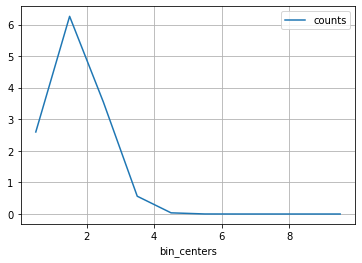

In [21]:
read_intermediate.plot('bin_centers', 'counts')

In [22]:
args = dict(v_0=233* nu.km / nu.s, 
                v_esc = 528* nu.km / nu.s, 
                rho_dm = 0.55 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
compare_shm = dddm.SHM(**args)
compare_spec = get_det_spec('Xe_migd', mw = 1, sigma = 10.**-39.02
             , nbins = 10, background = False, shm = compare_shm)

In [23]:
args = dict(v_0=233* nu.km / nu.s, 
                v_esc = 528* nu.km / nu.s, 
                rho_dm = 0.4 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
compare_shm = dddm.SHM(**args)
compare_spec2 = get_det_spec('Xe_migd', mw = 1, sigma = 10.**-39.02
             , nbins = 10, background = False, shm = compare_shm)

In [24]:
# args = dict(v_0=233* nu.km / nu.s, 
#                 v_esc = 528* nu.km / nu.s, 
#                 rho_dm = 0.21 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
# compare_shm = dddm.SHM(**args)
# compare_spec3 = get_det_spec('Xe_migd', mw = 1.14, sigma = 10.**-35.61
#              , nbins = 10, background = False, shm = compare_shm)

In [25]:
compare_shm.v_0 / (nu.km / nu.s)

232.99999999999997

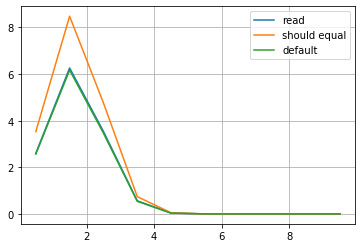

In [26]:
xs = read_intermediate['bin_centers'].values
plt.plot(xs, read_intermediate['counts'].values, label = 'read')
plt.plot(xs, compare_spec['counts'].values, label = 'should equal')
plt.plot(xs, compare_spec2['counts'].values, label = 'default')
# plt.plot(xs, compare_spec3['counts'].values, label = 'default-shm')
plt.legend()

In [27]:
args = dict(v_0=142.3* nu.km / nu.s, 
                v_esc = 503* nu.km / nu.s, 
                rho_dm = 0.21 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
compare_shm = dddm.SHM(**args)
compare_spec = get_det_spec('Xe_migd', mw = 1.14, sigma = 10.**-35.61
             , nbins = 10, background = False, shm = compare_shm)

In [28]:
args = dict(v_0=233* nu.km / nu.s, 
                v_esc = 528* nu.km / nu.s, 
                rho_dm = 0.55 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
compare_shm = dddm.SHM(**args)
compare_spec2 = get_det_spec('Xe_migd', mw = 1, sigma = 10.**-35
             , nbins = 10, background = False, shm = compare_shm)

In [29]:
args = dict(v_0=233* nu.km / nu.s, 
                v_esc = 528* nu.km / nu.s, 
                rho_dm = 0.21 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
compare_shm = dddm.SHM(**args)
compare_spec3 = get_det_spec('Xe_migd', mw = 1.14, sigma = 10.**-35.61
             , nbins = 10, background = False, shm = compare_shm)

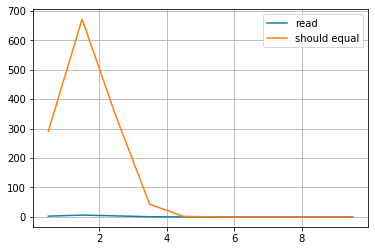

In [30]:
xs = read_intermediate['bin_centers'].values
plt.plot(xs, read_intermediate['counts'].values, label = 'read')
plt.plot(xs, compare_spec['counts'].values, label = 'should equal')
# plt.plot(xs, compare_spec2['counts'].values, label = 'default')
# plt.plot(xs, compare_spec3['counts'].values, label = 'default-shm')
plt.legend()

# Check likelihood function as function of v_0

In [52]:
from DirectDmTargets import SHM, log_likelihood, experiment, remove_nan
def plt_ll_sigma_mass_migd(spec_clas, vary, det='Xe_migdal', bins=10, m=1, sig=1e-40):
#     assert vary in ['mass', 'sig'], "use sig or mass"
    use_SHM = SHM(v_0=233* nu.km / nu.s, 
                  v_esc = 528* nu.km / nu.s, 
                  rho_dm = 0.55 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
    events = spec_clas(m, sig, use_SHM, experiment[det])
    events.n_bins = bins
    data = events.get_data(poisson=False)
    if vary == 'sig':
        plt.xlabel('$\sigma$ $[cm^2]$')
        plt.axvline(sig, alpha=0.5, color='red', label='truth')
#         var = np.linspace(0.1 * sig, 10 * sig, 30)
        var = np.concatenate((np.linspace(0.1 * sig, sig, 15),
                              np.linspace(sig, sig*3, 15)))

        def model(x):
            res = spec_clas(m, x, use_SHM, experiment[det])
            res.n_bins = bins
            return res.get_data(poisson=False)['counts']

    elif vary == 'mass':
        plt.xlabel('mass [GeV/$c^2$]')
        plt.axvline(m, alpha=0.5, color='red', label='truth')
        plt.axvline(m, alpha=0.1, color='black', label='binning boundary')
        var = np.concatenate((np.linspace(m/50, m, 15),
                              np.linspace(m, m*5, 15)))

        def model(x):
            res = spec_clas(x, sig, use_SHM, experiment[det])
            res.n_bins = bins
            return res.get_data(poisson=False)['counts']
    elif vary == 'v_0':
        plt.xlabel('v_0 [km/s]')
        plt.axvline(233, alpha=0.5, color='red', label='truth')
#         plt.axvline(233, alpha=0.1, color='black', label='binning boundary')
#         var = np.concatenate((np.linspace(1, 33, 50),
#                               np.linspace(33, 300, 50)))
        var = np.linspace(233 - 5 * 30, 233 + 8 * 30, 50)
        def model(x):
            use_SHM = SHM(
                  v_0=x* nu.km / nu.s, 
                  v_esc = 528* nu.km / nu.s, 
                  rho_dm = 0.55 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
            res = spec_clas(m, sig, use_SHM, experiment[det])
            res.n_bins = bins
            return res.get_data(poisson=False)['counts']
    plr = [log_likelihood(data['counts'], model(x)) for x in
           tqdm(var)]

    plt.xlim(var[0], var[-1])
    var, plr = remove_nan(var, plr), remove_nan(plr, var)
    plt.plot(var, plr, linestyle='steps-mid')
    plt.ylim(np.min(plr), np.max(plr))
    return var, plr


# def plt_ll_sigma_spec(det='Xe', bins=10, m=50, sig=1e-45):
#     plt_ll_sigma_mass(GenSpectrum, 'sig', det=det, bins=bins, m=m, sig=sig)


# def plt_ll_mass_spec(det='Xe', bins=10, m=50, sig=1e-45):
#     plt_ll_sigma_mass(GenSpectrum, 'mass', det=det, bins=bins, m=m, sig=sig)


def plt_ll_migd(det='Xe_migd', var = 'v_0' , bins=10, m=1, sig=1e-42):
    return plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, var, det=det, bins=bins, m=m, sig=sig)

100%|██████████| 50/50 [11:10<00:00, 13.41s/it]
<ipython-input-52-56ee939c76e8>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


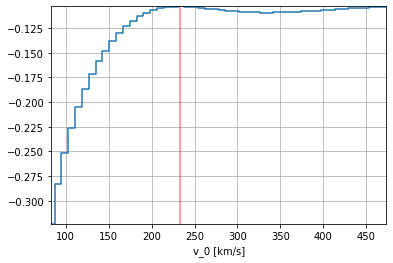

In [53]:
res = plt_ll_migd()

100%|██████████| 30/30 [06:12<00:00, 12.43s/it]
<ipython-input-44-f973a9c3dc95>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


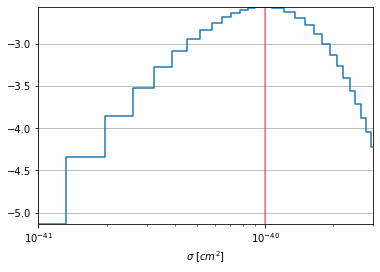

In [45]:
res2 = plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, 'sig', det='Xe_migd', bins=10, m=1, sig=1e-42)
plt.xscale("log")

100%|██████████| 30/30 [06:26<00:00, 12.88s/it]
<ipython-input-44-f973a9c3dc95>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


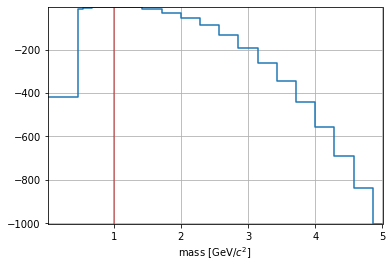

In [46]:
res3 = plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, 'mass', det='Xe_migd', bins=10, m=1, sig=1e-42)
# plt.xscale("log")

100%|██████████| 50/50 [00:02<00:00, 17.03it/s]
<ipython-input-52-56ee939c76e8>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


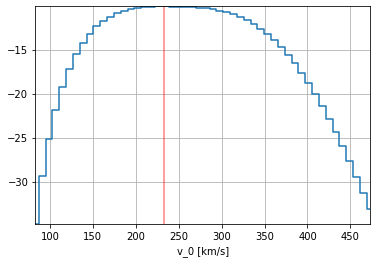

In [54]:
res4 = plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, 'v_0', det='Xe', bins=10, m=50, sig=1e-46)

100%|██████████| 50/50 [00:02<00:00, 17.05it/s]
<ipython-input-52-56ee939c76e8>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


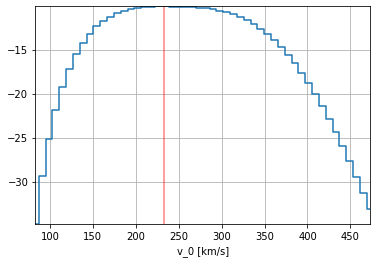

In [57]:
res4 = plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, 'v_0', det='Xe', bins=10, m=50, sig=1e-46)

100%|██████████| 50/50 [00:03<00:00, 16.42it/s]
<ipython-input-52-56ee939c76e8>:53: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


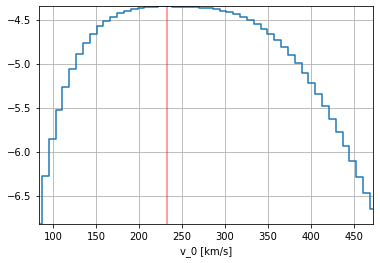

In [62]:
res5 = plt_ll_sigma_mass_migd(dddm.DetectorSpectrum, 'v_0', det='Xe', bins=10, m=50, sig=1e-47)

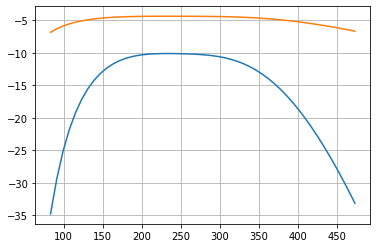

In [63]:
plt.plot(res4[0],res4[1])
plt.plot(res5[0],res5[1])